# 03 Calibration of Linear Reservoir Model

This notebook demonstrates how to calibrate a simple hydrological model against observed discharge.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from hydrograph_lab.io import read_hydrograph
from hydrograph_lab.models import linear_reservoir_model
from hydrograph_lab.calibration import calibrate_linear_reservoir
from hydrograph_lab.plotting_compare import plot_model_comparison
from hydrograph_lab.evaluation import evaluate_model

## 1. Load Data
We load observed discharge, precipitation, and (optionally) AET.

In [23]:
obs_path = "../obs.csv"
precip_path = "../precip.csv"
# aet_path = "../aet.csv"  # Optional

obs = read_hydrograph(obs_path, value_col="Q_obs")["Q_obs"]
precip = read_hydrograph(precip_path, value_col="precip")["precip"]

# Align data to common index (simple intersection)
data = pd.DataFrame({"obs": obs, "precip": precip}).dropna()
obs = data["obs"]
precip = data["precip"]

print(f"Data points aligned: {len(obs)}")
data.head()

Data points aligned: 24


,obs,precip
datetime,,
2024-01-01 00:00:00,10.0,2.0
2024-01-01 01:00:00,12.0,5.0
2024-01-01 02:00:00,15.0,0.0
2024-01-01 03:00:00,14.0,0.0
2024-01-01 04:00:00,16.0,0.0


## 2. Manual Simulation
Run the model with a guessed parameter (k).

Manual Run (k=0.2):
{'NSE': np.float64(-7.278994988434915), 'KGE': -0.5362905167723004, 'RMSE': 14.449301420857546, 'Bias': np.float64(-85.24552328492716), 'R': -0.15270167881988542, 'logNSE': np.float64(-42.50497303551258)}


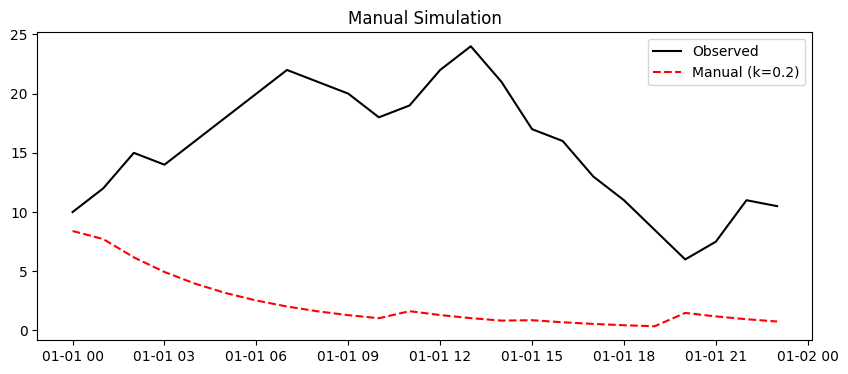

In [24]:
k_guess = 0.2
sim_manual = linear_reservoir_model(precip, k=k_guess, q0=obs.iloc[0])

metrics_manual = evaluate_model(obs.to_frame("Q_obs"), sim_manual.to_frame("Q_sim"), obs_col="Q_obs", sim_col="Q_sim")
print(f"Manual Run (k={k_guess}):")
print(metrics_manual)

plt.figure(figsize=(10, 4))
plt.plot(obs, label="Observed", color="black")
plt.plot(sim_manual, label=f"Manual (k={k_guess})", color="red", linestyle="--")
plt.legend()
plt.title("Manual Simulation")
plt.show()

## 3. Calibration
Optimize 'k' to maximize NSE.

In [25]:
result = calibrate_linear_reservoir(
    obs=obs,
    precip=precip,
    initial_k=0.5
)

print(f"Calibration Success: {result['success']}")
print(f"Best k: {result['best_k']:.4f}")
print("Calibrated Metrics:")
print(result["metrics"])

Calibration Success: True
Best k: 0.0010
Calibrated Metrics:
{'NSE': np.float64(-1.249770202730771), 'KGE': -0.2289914849676724, 'RMSE': 7.532291539588402, 'Bias': np.float64(-36.30370815670534), 'R': 0.3642532675146643, 'logNSE': np.float64(-1.11117937570413)}


## 4. Visualize Results

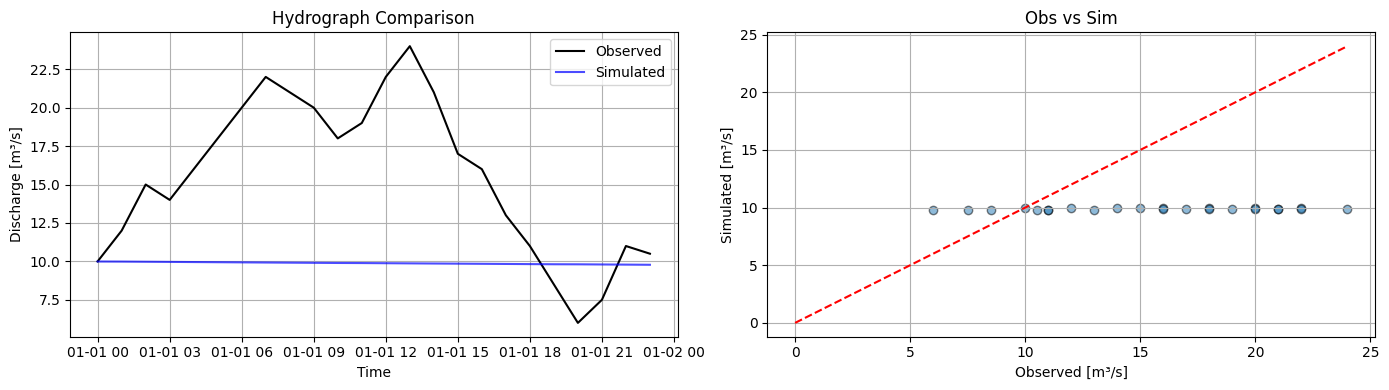

In [26]:
plot_model_comparison(obs, result["sim"])